In [2]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from collections import UserDict
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from math import sqrt

from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

from keras.callbacks import EarlyStopping
from math import sqrt

from pandas.tseries.offsets import DateOffset
import datetime
import time

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import datetime
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)
%matplotlib inline


Lets Download read in the data set, then subset it keeping only the variables needed


lets get the dataset AND SUBSET ON LTHE LAST 12 MONTHS

In [3]:
data= pd.read_csv('C:\\Users\\lydia\\OneDrive\\Msc Data Science\\CETM46 product development\\assigment 2 part2\\windapp\\T1.csv')



                           Data Cleaning

In [3]:
data.columns = ['Date','Power','Wind_speed','Theoretical_power','Wind_direction']

In [4]:
data.dtypes
data



,Date,Power,Wind_speed,Theoretical_power,Wind_direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


find missing values

In [5]:
data.isnull().sum()

Date                 0
Power                0
Wind_speed           0
Theoretical_power    0
Wind_direction       0
dtype: int64

I will delete NA as its a negligeable amount compared to our 200 thousand dataframe

In [6]:
data =data.dropna()
data.shape[0]

50530

remove  outliers

In [7]:
data = data[data.Power>0]

We identify some events when there is power produced by the turbine although wind speed is below threshold 3 m/s.

And we identify some events when there is ZERO power produced although wind speed is above 3 m/s and theoretical power is expected to be not ZERO. We see these happen most frequently in January and December.

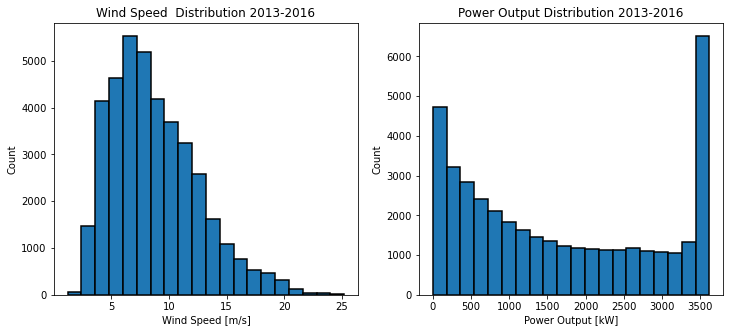

In [8]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(data['Wind_speed'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('Wind Speed  Distribution 2013-2016')
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Count')
ax2.hist(data['Power'],bins = 20, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Power Output Distribution 2013-2016')
ax2.set_xlabel('Power Output [kW]')
ax2.set_ylabel('Count')

plt.show()

In [9]:
df_clean = data[data['Wind_speed']>3]
df_clean = data[data['Wind_speed'] < 25]

df_clean.shape[0]

39691

lets see what we have now

lets create features to help us visualise our data better 

i also want to see how much loss based on theoretica output and actual output

In [10]:
df_clean['loss'] = df_clean['Theoretical_power'] - df_clean['Power']

In [11]:
df_clean['Date'] = pd.to_datetime(data['Date'])
df_clean.sort_values(by=['Date'], inplace=True, ascending=True)

df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Day'] =  df_clean['Date'].dt.day
df_clean['Hour'] =  df_clean['Date'].dt.hour
df_clean= df_clean.set_index('Date')


I want to train on the hourly production instead of the ten minute production 

In [12]:
#empty data frame
df_model =pd.DataFrame()


In [13]:

#total power outpuy per hour
df_model['Power'] =df_clean.resample('H').median().Power
#average wind direction per hour
df_model['Wind_direction']=df_clean.resample('H').median().Wind_direction
#average theoretical power
df_model['Theoretical_power'] = df_clean.resample('H').median().Theoretical_power
#average wind speed per hour
df_model['Wind_speed'] = df_clean.resample('H').median().Wind_speed

In [14]:
df_model = df_model.dropna()

lets create training testing and validation splits

In [15]:
valid_st_data_energy = pd.to_datetime('2018-10-12 23:00:00')
test_st_data_energy = pd.to_datetime('2018-11-12 23:00:00')

In [16]:

train = df_model[df_model.index <valid_st_data_energy]
validation = df_model.loc[(df_model.index >=valid_st_data_energy)&(df_model.index <test_st_data_energy )]

test = df_model[df_model.index > test_st_data_energy ]


In [17]:
train 

,Power,Wind_direction,Theoretical_power,Wind_speed
Date,,,,
2018-01-01 00:00:00,391.521347,267.157700,495.569678,5.590997
2018-01-01 01:00:00,455.628464,258.336639,514.759525,5.654372
2018-01-01 02:00:00,745.607452,266.746796,796.689574,6.476018
2018-01-01 03:00:00,861.139801,255.956100,876.253921,6.667778
2018-01-01 04:00:00,1439.648010,246.694801,1479.699757,7.911346
...,...,...,...,...
2018-10-12 18:00:00,780.665955,36.541515,718.881214,6.267241
2018-10-12 19:00:00,877.244263,17.247205,767.102484,6.391208
2018-10-12 20:00:00,885.671204,335.033661,813.095535,6.515735


lets split to different turbine specific data frames

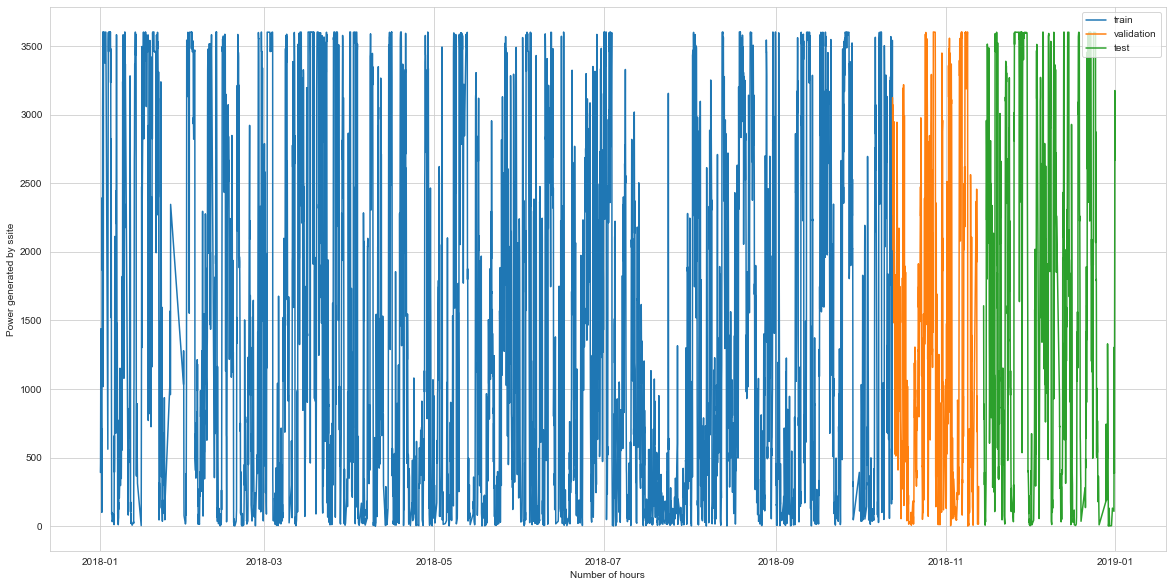

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
plt.plot(train['Power'],label="train")
plt.plot(validation['Power'],label="validation")
plt.plot(test['Power'],label="test")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("Power generated by ssite")
plt.show()

letd create individual time series out of each turbine

In [19]:
def make_timeseries(data):
    '''takes the sight and returns univariet time series'''
    Turbine = pd.DataFrame(data['Power'])
    return(Turbine)

In [20]:
ts_train = make_timeseries(train)
ts_validation = make_timeseries(validation)
ts_test = make_timeseries(test)



In [21]:
df_model.isnull().sum()

Power                0
Wind_direction       0
Theoretical_power    0
Wind_speed           0
dtype: int64

           lets plot the different outputs of all work with one trubine for now then repeate for all of them

AttributeError: 'WindroseAxes' object has no attribute 'show'

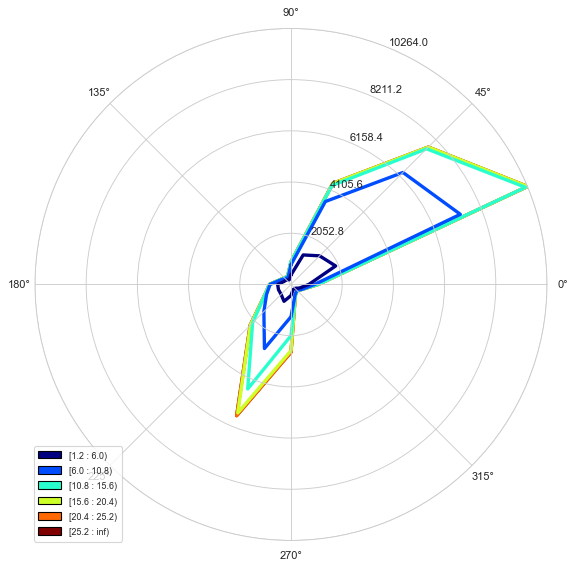

In [49]:
from windrose import plot_windrose

fig = plot_windrose(data, kind='contour',direction_name='Wind_direction',var_name='Wind_speed',  lw=3)

fig.show

In [39]:
data[-10:]

,Date,Power,Wind_speed,Theoretical_power,Wind_direction
50520,31 12 2018 22:20,2771.110107,10.154550,2884.512812,82.335197
50521,31 12 2018 22:30,3333.819092,12.067660,3532.081496,81.985901
50522,31 12 2018 22:40,3455.282959,12.195660,3549.150371,82.210617
50523,31 12 2018 22:50,3429.021973,12.492510,3578.567804,82.111870
50524,31 12 2018 23:00,3514.269043,12.559170,3583.288363,80.495262
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


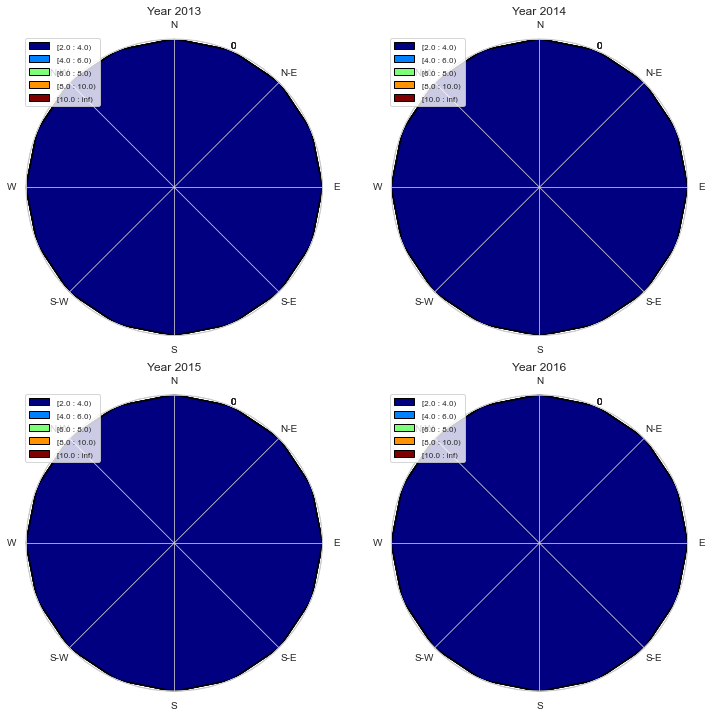

In [23]:
warnings.filterwarnings(action='once')
f = plt.figure(figsize=(12,12))
leg_pos = 'upper left'

ax1 = f.add_subplot(221,projection='windrose')
ax1.set_title('Year 2013')
anno=2013

ax1.contourf(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'], 
             bins = np.arange(2, 12, 2))
ax1.contour(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'],
            colors='black',bins = np.arange(2, 12, 2))
ax1.set_legend(loc=leg_pos)

ax2 = f.add_subplot(222,projection='windrose')
ax2.set_title('Year 2014')
anno=2014

ax2.contourf(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'], 
             bins = np.arange(2, 12, 2))
ax2.contour(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'],
            colors='black',bins = np.arange(2, 12, 2))
ax2.set_legend(loc=leg_pos)

ax3 = f.add_subplot(223,projection='windrose')
ax3.set_title('Year 2015')
anno=2015

ax3.contourf(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'], 
             bins = np.arange(2, 12, 2))
ax3.contour(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'],
            colors='black',bins = np.arange(2, 12, 2))
ax3.set_legend(loc=leg_pos)

ax4 = f.add_subplot(224,projection='windrose')
ax4.set_title('Year 2016')
anno=2016

ax4.contourf(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'], 
             bins = np.arange(2, 12, 2))
ax4.contour(df_clean.loc[df_clean['Year']==anno,'Wind_direction'], df_clean.loc[df_clean['Year']==anno,'Wind_speed'],
            colors='black',bins = np.arange(2, 12, 2))
ax4.set_legend(loc=leg_pos)

plt.show()

            lets create our training function that all the timeseries will use
            

In [24]:
def trainer(Train,Validation,data):
    scaler = MinMaxScaler()
    scaler.fit(Train)    
    
    train = scaler.transform(Train)
    validation =scaler.transform(Validation)

    #lets define inputs params
    n_input = 6
    n_features = 1
    train_generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)
    validation_generator = TimeseriesGenerator(validation, validation, length=n_input, batch_size=32)

    model = Sequential()

    model.add(LSTM(units = 50,activation = 'relu', return_sequences = True,input_shape=(n_input, n_features)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 60,activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3))

    model.add(LSTM(units = 80,activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 120,activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))


    model.compile(optimizer='adam', loss='mse')

    EARLY_STOP= EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

    history = model.fit(train_generator,epochs=1000,
                              validation_data =validation_generator,
                              callbacks= [EARLY_STOP],
                              verbose=1)
    
    test = DataFrame(data['Power'][0:200])
    
    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, n_features))
    for i in range(n_input):   
        pred_list.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

    add_dates = [test.index[-1] + DateOffset(hours=x) for x in range(0,7) ]
    future_dates = pd.DataFrame(index=add_dates[1:],columns=test.columns)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=future_dates[-n_input:].index, columns=['Prediction'])
    df_proj = pd.concat([test,df_predict], axis=1)


    plot_data = [
        go.Scatter(
            x=df_proj.index,
            y=df_proj['Power'],
            name='actual'
        ),
        go.Scatter(
            x=df_proj.index,
            y=df_proj['Prediction'],
            name='prediction'
        )
    ]
    plot_layout = go.Layout(
            title='Power'
        )
    fig = go.Figure(data=plot_data, layout=plot_layout)
    graph= pyoff.iplot(fig)

    return(model, history,graph,scaler,df_proj)

In [25]:
ts_test

,Power
Date,
2018-11-14 17:00:00,1607.254517
2018-11-14 18:00:00,1198.862671
2018-11-14 19:00:00,781.769653
2018-11-14 20:00:00,890.272705
2018-11-14 21:00:00,870.432159
...,...
2018-12-31 19:00:00,934.974701
2018-12-31 20:00:00,1571.804993
2018-12-31 21:00:00,2116.489441


In [26]:
model, history,plot,scaler,table, = trainer(ts_train, ts_validation,ts_test)

Epoch 1/1000
173/173 [==============================] - 5s 29ms/step - loss: 0.1038 - val_loss: 0.0635
Epoch 2/1000
173/173 [==============================] - 4s 23ms/step - loss: 0.0676 - val_loss: 0.0526
Epoch 3/1000
173/173 [==============================] - 4s 21ms/step - loss: 0.0597 - val_loss: 0.0444
Epoch 4/1000
173/173 [==============================] - 3s 18ms/step - loss: 0.0500 - val_loss: 0.0376
Epoch 5/1000
173/173 [==============================] - 3s 18ms/step - loss: 0.0440 - val_loss: 0.0288
Epoch 6/1000
173/173 [==============================] - 3s 18ms/step - loss: 0.0391 - val_loss: 0.0294
Epoch 7/1000
173/173 [==============================] - 3s 20ms/step - loss: 0.0365 - val_loss: 0.0268
Epoch 8/1000
173/173 [==============================] - 4s 21ms/step - loss: 0.0357 - val_loss: 0.0251
Epoch 9/1000
173/173 [==============================] - 4s 22ms/step - loss: 0.0337 - val_loss: 0.0234
Epoch 10/1000
173/173 [==============================] - 4s 23ms/step - l

In [27]:
table.tail()

,Power,Prediction
2018-11-23 11:00:00,NaN,2686.200146
2018-11-23 12:00:00,NaN,2712.819571
2018-11-23 13:00:00,NaN,2743.841449
2018-11-23 14:00:00,NaN,2762.145700
2018-11-23 15:00:00,NaN,2766.553739


In [28]:
def ploter_predictor(model,scaler,new_data):
    
    '''note: in jupyter file its defined as plotter
    takes new data, site and site specific model and predicts the next 6 time steps

     Parameters:
     site(str): site column name as shown in data frame
     model(object): model object specific to that site
     new_data(dataframe): data comforming to the training data frame and must have atleast 13 past observations
     

     Returns:
     returns table with actual values and predictions for that site. and RMSE and MAPE
    
    '''
    from pandas import DataFrame
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    from pandas.tseries.offsets import DateOffset

    data = new_data
    Train = DataFrame(data['Power']).tail(20)
    scaler = scaler    
    train = scaler.transform(Train)
    
    #lets define inputs params
    n_input = 6
    n_features = 1
    
    test = DataFrame(data['Power']).tail(20)
    
    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, n_features))
    
    #get metrics by creating current predictions
    pred_list = []
    batch = train[-12:-6].reshape((1, n_input, n_features))
    for i in range(1,6):   
        pred_list.append(model.predict(batch)[0]) 
        batch = train[-12+i:-6+i].reshape((1, n_input, n_features))

    batch= train[-7:-1].reshape((1, n_input, n_features))
    pred_list.append(model.predict(batch)[0])

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=test[-n_input:].index, columns=['Prediction'])
    df_predict = pd.concat([test,df_predict], axis=1)

    #get future metrics
    pred_list2 = []
    batch = train[-n_input:].reshape((1, n_input, n_features))

    for i in range(n_input):   
        pred_list2.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list2[i]]],axis=1)

    add_dates = [test.index[-1] + DateOffset(hours=x) for x in range(0,7) ]
    future_dates = pd.DataFrame(index=add_dates[1:],columns=test.columns)


    df_pred = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=future_dates[-n_input:].index, columns=['Prediction'])
    df_proj = pd.concat([df_predict,df_pred[-6:]], axis=0, ignore_index=False)
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    
    #get metrics
    metdata = df_proj.dropna()    
    RMSE = mean_squared_error(metdata['Power'], 
                            metdata['Prediction'],squared = False)
    MAPE = mean_absolute_percentage_error(metdata['Power'],
                                          metdata['Prediction'])

    return(df_proj.tail(17),RMSE,MAPE)


In [30]:
ploter_predictor(model,scaler,ts_test)

(                           Power   Prediction
 2018-12-31 01:00:00   131.578098          NaN
 2018-12-31 14:00:00   108.247452          NaN
 2018-12-31 15:00:00   492.586594          NaN
 2018-12-31 16:00:00  1304.573486          NaN
 2018-12-31 17:00:00   395.041840          NaN
 2018-12-31 18:00:00   385.866699   870.012301
 2018-12-31 19:00:00   934.974701   593.044059
 2018-12-31 20:00:00  1571.804993   898.101305
 2018-12-31 21:00:00  2116.489441  1591.658261
 2018-12-31 22:00:00  3176.856079  2099.119063
 2018-12-31 23:00:00  2668.080078  2607.522389
 2019-01-01 00:00:00          NaN   870.012301
 2019-01-01 01:00:00          NaN   593.044059
 2019-01-01 02:00:00          NaN   898.101305
 2019-01-01 03:00:00          NaN  1591.658261
 2019-01-01 04:00:00          NaN  2099.119063
 2019-01-01 05:00:00          NaN  2607.522389,
 611.8036535786968,
 0.44315691667254137)

In [31]:

model.save('T_model.h5')

In [32]:
from pickle import dump
wp1_scaler=dump(scaler, open('T_scaler.pkl', 'wb'))

C:\Users\lydia\AppData\Local\Temp/ipykernel_16936/2554198543.py:2: ResourceWarning:

unclosed file <_io.BufferedWriter name='T_scaler.pkl'>



                                            Turbine1
    